In [1]:
import jax
import jax.numpy as jnp

import optax
import flax
from flax import linen as nn

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import wandb
from wandb.apis.public import Api

from tqdm import tqdm
from typing import NamedTuple, Dict, List, Tuple
from itertools import combinations_with_replacement, product
import time
from dataclasses import dataclass

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Setup

In [2]:
# Configuration
PROJECT_NAME = "induced_metric"
RUN_INDEX = 1  # Change this to analyze different run indices
ENTITY_NAME = "thomas_harvey"

# Speedrun target validation losses
SPEEDRUN_TARGETS = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]

# Optimizer names to analyze
OPTIMISERS = ['adam', 'adamw', 'sgd', 'sgd_metric', 'sgd_log_metric', 'muon' ,'sgd_rms']

print(f"Analyzing run index: {RUN_INDEX}")
print(f"Project: {PROJECT_NAME}")
print(f"Optimisers: {OPTIMISERS}")
print(f"Speedrun targets: {SPEEDRUN_TARGETS}")

api = Api()

Analyzing run index: 1
Project: induced_metric
Optimisers: ['adam', 'adamw', 'sgd', 'sgd_metric', 'sgd_log_metric', 'muon', 'sgd_rms']
Speedrun targets: [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05]


# Prepare Data

In [14]:
# Get the best run for each optimizer directly using API sorting
best_runs = {}
best_50_runs = {}

for optimizer in OPTIMISERS:
    print(f"Finding best run for {optimizer}...")
    
    # Get runs sorted by min_val_loss (ascending = best first)
    optimizer_runs = api.runs(
        PROJECT_NAME, 
        filters={
            "$and": [
                {"tags": "regression"}, 
                {"tags": f"run_{RUN_INDEX}"}, 
                {"tags": optimizer}
            ]
        },
        order="+summary_metrics.min_val_loss"  # + for ascending order
    )
    
    # Take the first run (best one)
    if len(optimizer_runs) > 0:
        best_run = optimizer_runs[0]
        best_50_runs[optimizer] = optimizer_runs[:50]
        best_min_val_loss = best_run.summary.get('min_val_loss', None)
        
        if best_min_val_loss is not None:
            best_runs[optimizer] = best_run
            print(f"{optimizer}: {best_run.name} (min_val_loss: {best_min_val_loss:.4f})")
        else:
            print(f"{optimizer}: No valid min_val_loss found in best run")
    else:
        print(f"{optimizer}: No runs found")

print(f"\nFound best runs for {len(best_runs)} optimizers")

Finding best run for adam...
adam: fearless-sweep-454 (min_val_loss: 0.0212)
Finding best run for adamw...
adamw: quiet-sweep-65 (min_val_loss: 0.0251)
Finding best run for sgd...
sgd: autumn-sweep-136 (min_val_loss: 0.0363)
Finding best run for sgd_metric...
sgd_metric: pious-sweep-28 (min_val_loss: 0.0315)
Finding best run for sgd_log_metric...
sgd_log_metric: rosy-sweep-190 (min_val_loss: 0.0315)
Finding best run for muon...
muon: divine-sweep-97 (min_val_loss: 0.0343)
Finding best run for sgd_rms...
sgd_rms: glowing-sweep-137 (min_val_loss: 0.0229)

Found best runs for 7 optimizers


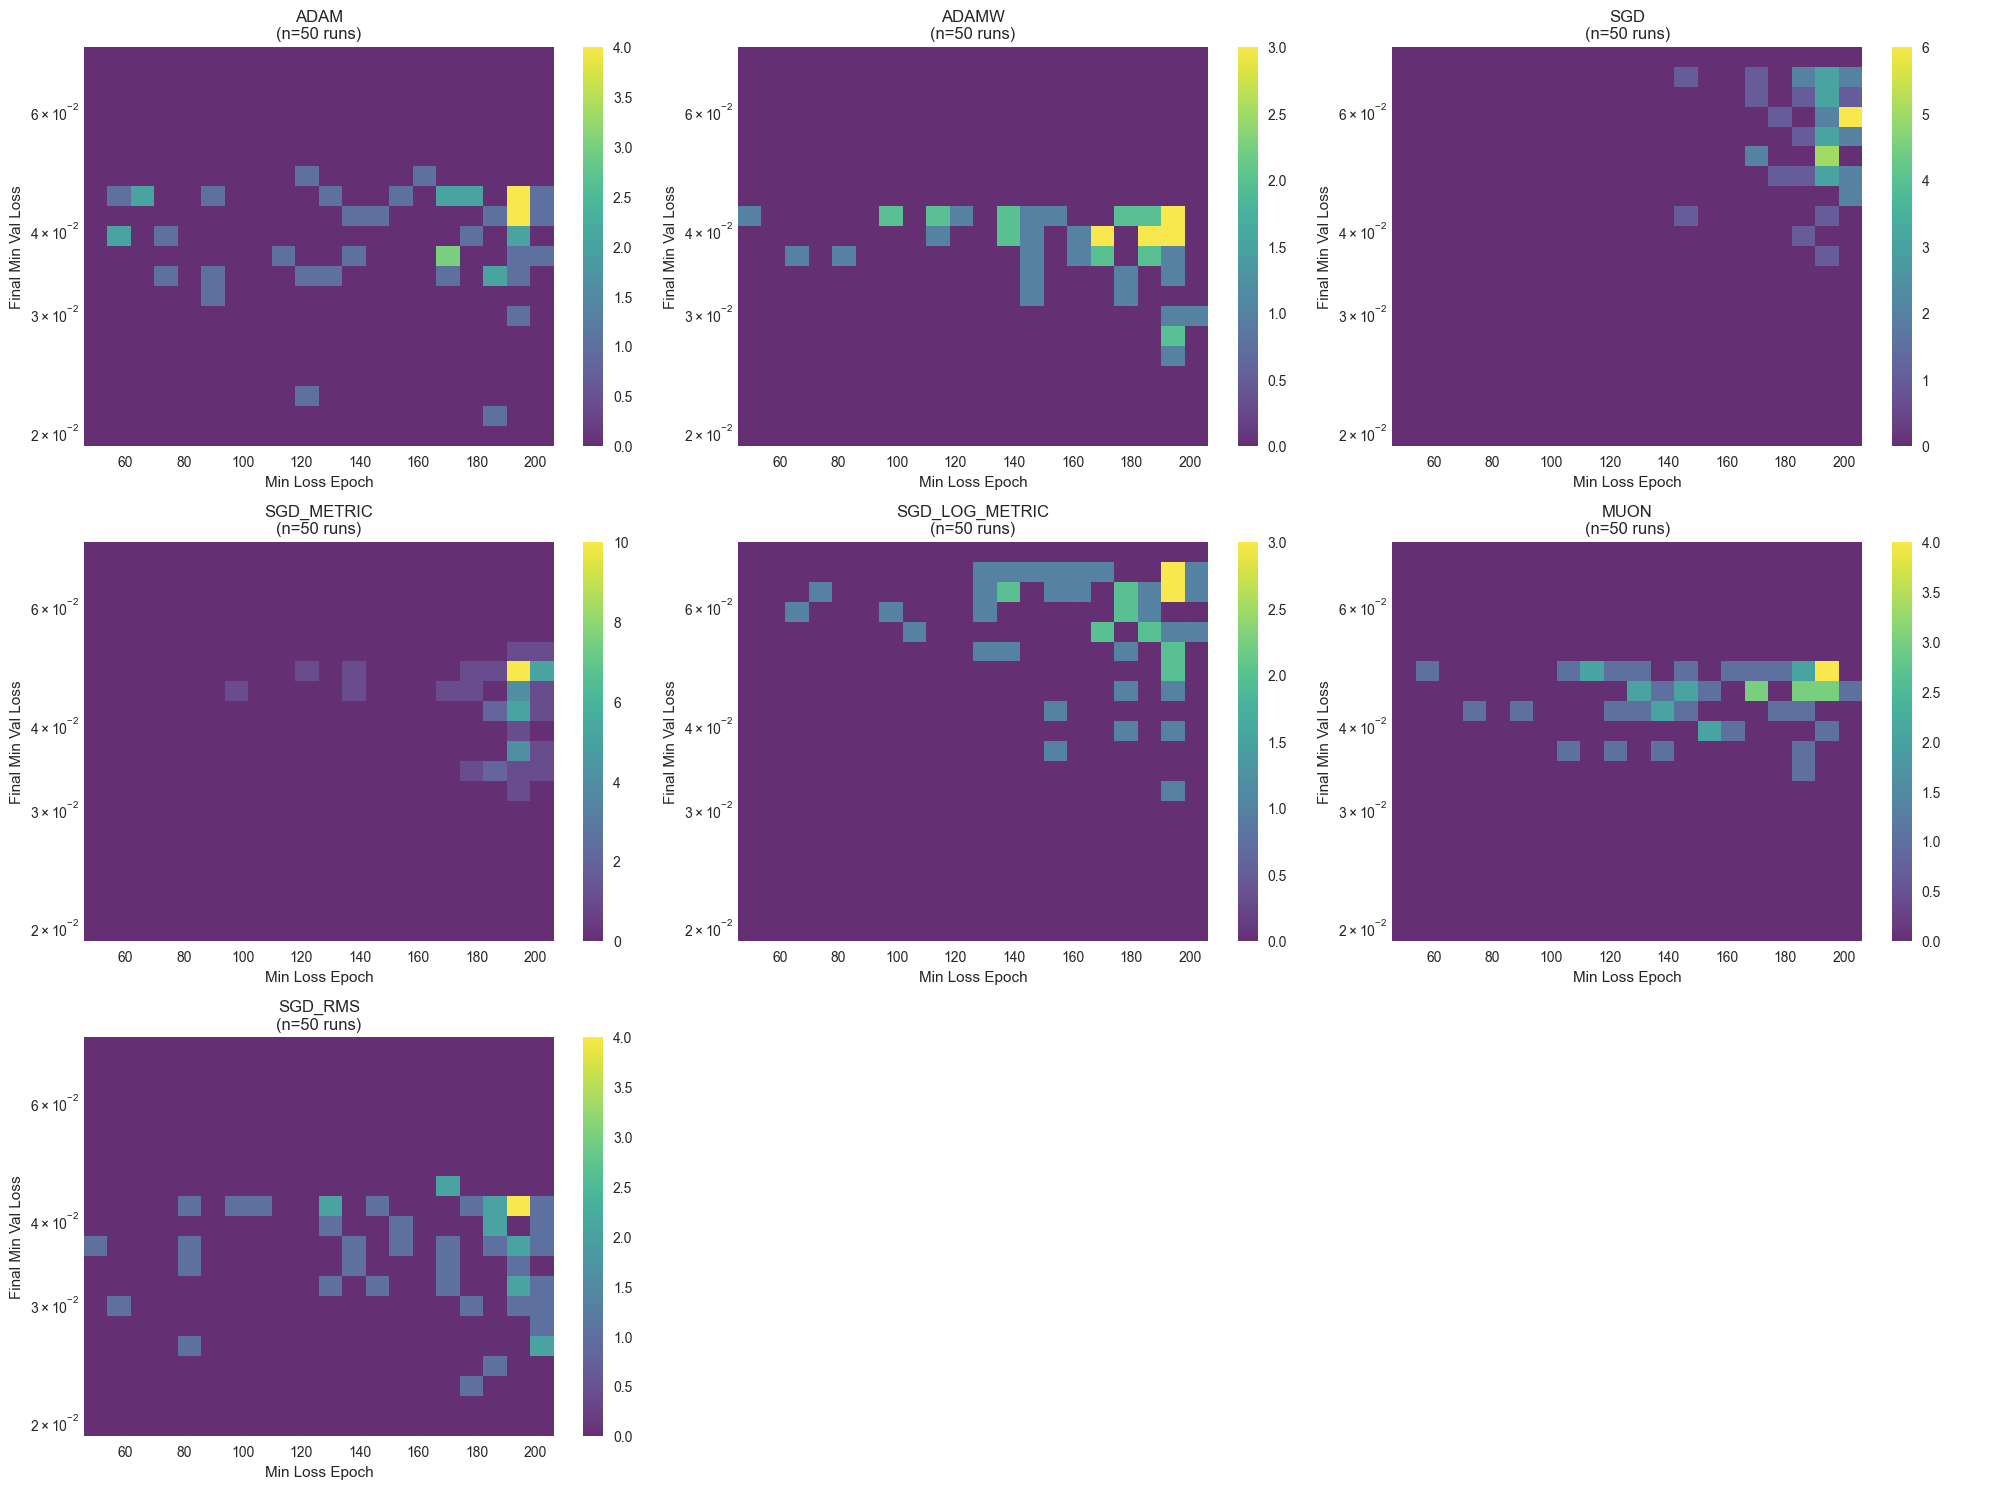

Summary Statistics: Min Val Loss vs Min Loss Epoch

ADAM:
  Runs with data: 50
  Min Val Loss - Mean: 0.039413, Std: 0.005714
  Min Loss Epoch - Mean: 152.6, Std: 47.3
  Best Min Val Loss: 0.021170 at epoch 184

ADAMW:
  Runs with data: 50
  Min Val Loss - Mean: 0.037851, Std: 0.004409
  Min Loss Epoch - Mean: 161.3, Std: 37.3
  Best Min Val Loss: 0.025141 at epoch 196

SGD:
  Runs with data: 50
  Min Val Loss - Mean: 0.055665, Std: 0.008234
  Min Loss Epoch - Mean: 191.0, Std: 11.9
  Best Min Val Loss: 0.036319 at epoch 196

SGD_METRIC:
  Runs with data: 50
  Min Val Loss - Mean: 0.043493, Std: 0.005302
  Min Loss Epoch - Mean: 188.2, Std: 20.1
  Best Min Val Loss: 0.031509 at epoch 198

SGD_LOG_METRIC:
  Runs with data: 50
  Min Val Loss - Mean: 0.057149, Std: 0.008967
  Min Loss Epoch - Mean: 167.0, Std: 33.0
  Best Min Val Loss: 0.031528 at epoch 198

MUON:
  Runs with data: 50
  Min Val Loss - Mean: 0.043898, Std: 0.003694
  Min Loss Epoch - Mean: 155.7, Std: 35.0
  Best Min Val L

In [4]:
# Create 2D histograms for each optimizer showing final_min_val_loss vs final_min_loss_epoch
# with normalized axes for easier comparison
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

# First pass: collect global min/max values for consistent scaling
all_min_val_losses = []
all_min_loss_epochs = []

for optimizer in OPTIMISERS:
    if optimizer in best_50_runs:
        for run in best_50_runs[optimizer]:
            min_val_loss = run.summary.get('min_val_loss', None)
            min_loss_epoch = run.summary.get('min_loss_epoch', None)
            
            if min_val_loss is not None and min_loss_epoch is not None:
                all_min_val_losses.append(min_val_loss)
                all_min_loss_epochs.append(min_loss_epoch)

# Calculate global ranges for consistent axes
if all_min_val_losses:
    global_loss_min = min(all_min_val_losses)
    global_loss_max = max(all_min_val_losses)
    global_epoch_min = min(all_min_loss_epochs)
    global_epoch_max = max(all_min_loss_epochs)
    
    # Add some padding
    loss_range = global_loss_max - global_loss_min
    epoch_range = global_epoch_max - global_epoch_min
    
    loss_bins = np.logspace(np.log10(global_loss_min * 0.9), np.log10(global_loss_max * 1.1), 21)
    epoch_bins = np.linspace(global_epoch_min - epoch_range * 0.05, global_epoch_max + epoch_range * 0.05, 21)

# Second pass: create histograms with consistent bins
for i, optimizer in enumerate(OPTIMISERS):
    if optimizer in best_50_runs:
        # Collect data from the best 50 runs
        min_val_losses = []
        min_loss_epochs = []
        
        for run in best_50_runs[optimizer]:
            min_val_loss = run.summary.get('min_val_loss', None)
            min_loss_epoch = run.summary.get('min_loss_epoch', None)
            
            if min_val_loss is not None and min_loss_epoch is not None:
                min_val_losses.append(min_val_loss)
                min_loss_epochs.append(min_loss_epoch)
        
        if len(min_val_losses) > 0:
            # Create 2D histogram with consistent bins
            h = axes[i].hist2d(min_loss_epochs, min_val_losses, 
                              bins=[epoch_bins, loss_bins], 
                              cmap='viridis', alpha=0.8)
            
            # Add colorbar
            plt.colorbar(h[3], ax=axes[i])
            
            # Set title and labels
            axes[i].set_title(f'{optimizer.upper()}\n(n={len(min_val_losses)} runs)')
            axes[i].set_xlabel('Min Loss Epoch')
            axes[i].set_ylabel('Final Min Val Loss')
            axes[i].grid(True, alpha=0.3)
            
            # Set consistent axis limits and log scale for y-axis
            axes[i].set_xlim(global_epoch_min - epoch_range * 0.05, global_epoch_max + epoch_range * 0.05)
            axes[i].set_ylim(global_loss_min * 0.9, global_loss_max * 1.1)
            axes[i].set_yscale('log')
        else:
            axes[i].text(0.5, 0.5, f'No data for {optimizer}', 
                        ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{optimizer.upper()}\n(No data)')

# Hide any unused subplots
for j in range(len(OPTIMISERS), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Create a summary statistics table
print("Summary Statistics: Min Val Loss vs Min Loss Epoch")
print("=" * 80)

for optimizer in OPTIMISERS:
    if optimizer in best_50_runs:
        min_val_losses = []
        min_loss_epochs = []

        for run in best_50_runs[optimizer]:
            min_val_loss = run.summary.get('min_val_loss', None)
            min_loss_epoch = run.summary.get('min_loss_epoch', None)
            
            if min_val_loss is not None and min_loss_epoch is not None:
                min_val_losses.append(min_val_loss)
                min_loss_epochs.append(min_loss_epoch)
        
        if len(min_val_losses) > 0:
            print(f"\n{optimizer.upper()}:")
            print(f"  Runs with data: {len(min_val_losses)}")
            print(f"  Min Val Loss - Mean: {np.mean(min_val_losses):.6f}, Std: {np.std(min_val_losses):.6f}")
            print(f"  Min Loss Epoch - Mean: {np.mean(min_loss_epochs):.1f}, Std: {np.std(min_loss_epochs):.1f}")
            print(f"  Best Min Val Loss: {np.min(min_val_losses):.6f} at epoch {min_loss_epochs[np.argmin(min_val_losses)]}")

In [5]:
# Collect data for all optimizers
optimizer_data = {}

for optimizer, run in best_runs.items():
    print(f"Processing {optimizer}...")
    
    # Get history data
    history = run.scan_history()
    
    # Collect data
    epochs = []
    train_mses = []
    test_mses = []
    runtimes = []
    
    for row in history:
        if 'epoch' in row and row['epoch'] is not None:
            epochs.append(row['epoch'])
            train_mses.append(row.get('train_mse', None))
            test_mses.append(row.get('test_mse', None))
            runtimes.append(row.get('train_time_seconds', None))
            
    first_estimated_runtime = (runtimes[0] -  runtimes[-1])/(len(runtimes) - 1) if len(runtimes) > 1 else 0
    runtimes = [-rt+runtimes[0] + first_estimated_runtime for rt in runtimes if rt is not None]

    # Get start time for wall-time calculation
    start_time = runtimes[0] if runtimes else 0
    wall_times = [rt - start_time for rt in runtimes]
    # estimate wall time for first epoch without JIT compilation

    
    # Sample every sample-count epoch plus the last epoch
    sample_count = 1
    valid_indices = list(range(0, len(epochs), sample_count))
    if len(epochs) - 1 not in valid_indices:
        valid_indices.append(len(epochs) - 1)
    
    # Filter data
    epochs_filtered = np.array([epochs[i] for i in valid_indices])
    train_mses_filtered = np.array([train_mses[i] for i in valid_indices if train_mses[i] is not None])
    test_mses_filtered = np.array([test_mses[i] for i in valid_indices if test_mses[i] is not None])
    wall_times_filtered = np.array([wall_times[i] for i in valid_indices])
    
    # Ensure all arrays have the same length
    min_length = min(len(epochs_filtered), len(train_mses_filtered), len(test_mses_filtered), len(wall_times_filtered))
    
    optimizer_data[optimizer] = {
        'epochs': epochs_filtered[:min_length],
        'train_mses': train_mses_filtered[:min_length],
        'test_mses': test_mses_filtered[:min_length],
        'wall_times': wall_times_filtered[:min_length]
    }

print(f"\nProcessed data for {len(optimizer_data)} optimizers")

Processing adam...
Processing adamw...
Processing sgd...
Processing sgd_metric...
Processing sgd_log_metric...
Processing muon...
Processing sgd_rms...

Processed data for 7 optimizers


Time to reach best validation loss for each optimizer's best run:
ADAM           :     0.21s at epoch 184 (test_mse: 0.021170)
ADAMW          :     0.24s at epoch 196 (test_mse: 0.025141)
SGD            :     0.20s at epoch 196 (test_mse: 0.036319)
SGD_METRIC     :     0.20s at epoch 198 (test_mse: 0.031509)
SGD_LOG_METRIC :     0.23s at epoch 198 (test_mse: 0.031528)
MUON           :     0.46s at epoch 190 (test_mse: 0.034348)
SGD_RMS        :     0.22s at epoch 178 (test_mse: 0.022890)


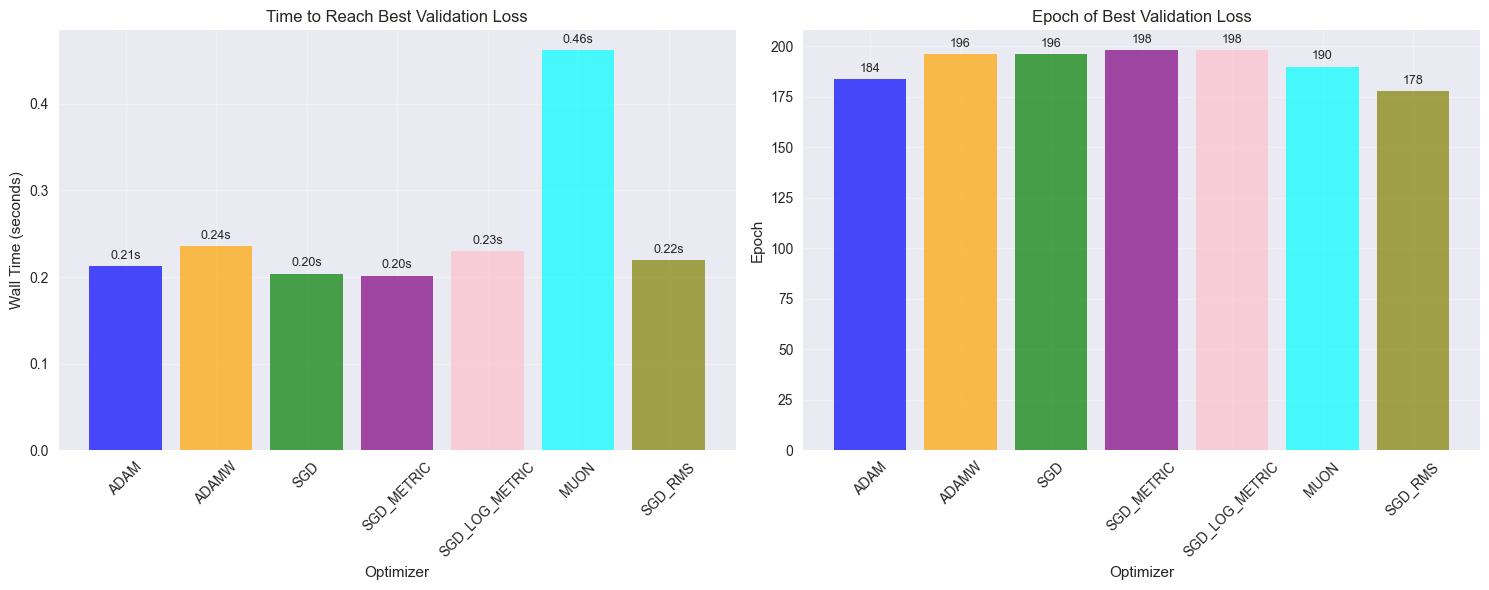


Summary Statistics:
Fastest to best loss: SGD_METRIC (0.20s)
Slowest to best loss: MUON (0.46s)
Earliest epoch: SGD_RMS (epoch 178)
Latest epoch: SGD_METRIC (epoch 198)


In [7]:
optimizer_colors = {
    'sgd_rms': 'olive',
    'adam': 'blue',
    'adamw': 'orange',
    'sgd': 'green',
    'sgd_metric': 'purple',
    'sgd_log_metric': 'pink',
    'muon': 'cyan'
}

# Extract time to reach best validation loss for each optimizer's best run
best_times = {}

print("Time to reach best validation loss for each optimizer's best run:")
print("=" * 70)

for optimizer in OPTIMISERS:
    if optimizer in best_runs and optimizer in optimizer_data:
        # Get the min_loss_epoch from the best run summary
        best_run = best_runs[optimizer]
        min_loss_epoch = best_run.summary.get('min_loss_epoch', None)
        
        if min_loss_epoch is not None:
            # Find the corresponding wall time from optimizer_data
            data = optimizer_data[optimizer]
            
            # Find the index where epoch equals min_loss_epoch
            epoch_indices = np.where(data['epochs'] == min_loss_epoch)[0]
            
            if len(epoch_indices) > 0:
                epoch_idx = epoch_indices[0]
                wall_time_to_best = data['wall_times'][epoch_idx]
                test_mse_at_best = data['test_mses'][epoch_idx]
                
                best_times[optimizer] = {
                    'epoch': min_loss_epoch,
                    'wall_time': wall_time_to_best,
                    'test_mse': test_mse_at_best
                }
                
                print(f"{optimizer.upper():<15}: {wall_time_to_best:>8.2f}s at epoch {min_loss_epoch:>3d} (test_mse: {test_mse_at_best:.6f})")
            else:
                print(f"{optimizer.upper():<15}: Epoch {min_loss_epoch} not found in data")
        else:
            print(f"{optimizer.upper():<15}: No min_loss_epoch found")

# Create a comparison plot
if best_times:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    optimizers_list = list(best_times.keys())
    wall_times_list = [best_times[opt]['wall_time'] for opt in optimizers_list]
    epochs_list = [best_times[opt]['epoch'] for opt in optimizers_list]
    colors_list = [optimizer_colors[opt] for opt in optimizers_list]
    
    # Plot wall times
    bars1 = ax1.bar(range(len(optimizers_list)), wall_times_list, color=colors_list, alpha=0.7)
    ax1.set_xlabel('Optimizer')
    ax1.set_ylabel('Wall Time (seconds)')
    ax1.set_title('Time to Reach Best Validation Loss')
    ax1.set_xticks(range(len(optimizers_list)))
    ax1.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.annotate(f'{height:.2f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    # Plot epochs
    bars2 = ax2.bar(range(len(optimizers_list)), epochs_list, color=colors_list, alpha=0.7)
    ax2.set_xlabel('Optimizer')
    ax2.set_ylabel('Epoch')
    ax2.set_title('Epoch of Best Validation Loss')
    ax2.set_xticks(range(len(optimizers_list)))
    ax2.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for i, bar in enumerate(bars2):
        height = bar.get_height()
        ax2.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print(f"\nSummary Statistics:")
    print(f"Fastest to best loss: {min(best_times.items(), key=lambda x: x[1]['wall_time'])[0].upper()} ({min(wall_times_list):.2f}s)")
    print(f"Slowest to best loss: {max(best_times.items(), key=lambda x: x[1]['wall_time'])[0].upper()} ({max(wall_times_list):.2f}s)")
    print(f"Earliest epoch: {min(best_times.items(), key=lambda x: x[1]['epoch'])[0].upper()} (epoch {min(epochs_list)})")
    print(f"Latest epoch: {max(best_times.items(), key=lambda x: x[1]['epoch'])[0].upper()} (epoch {max(epochs_list)})")

# Train and validation loss curves

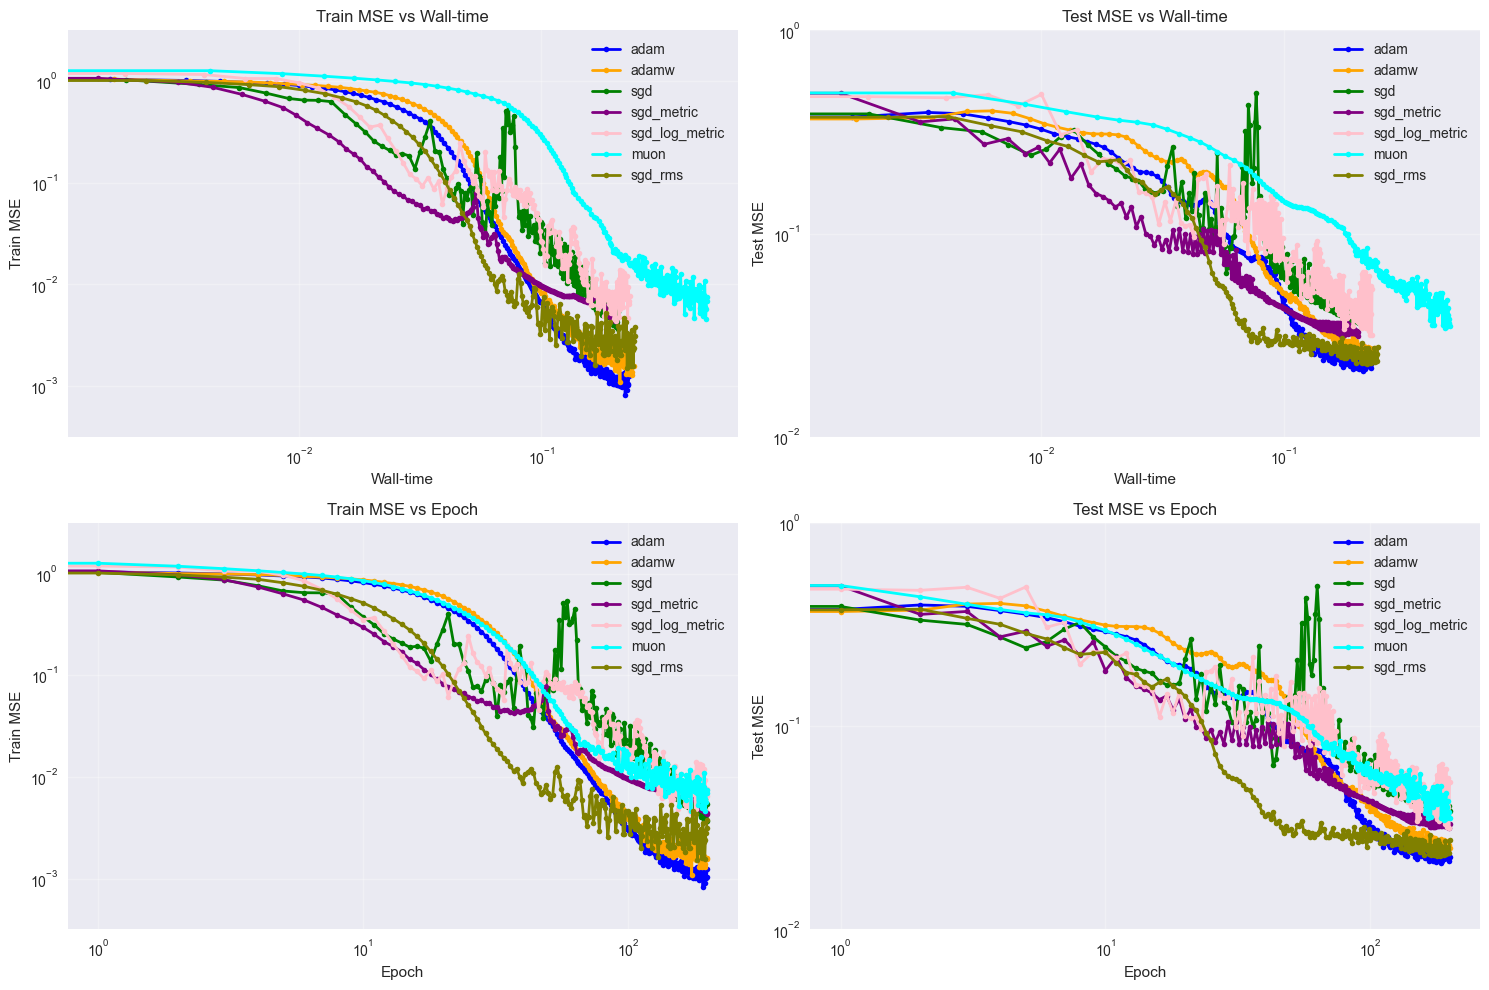

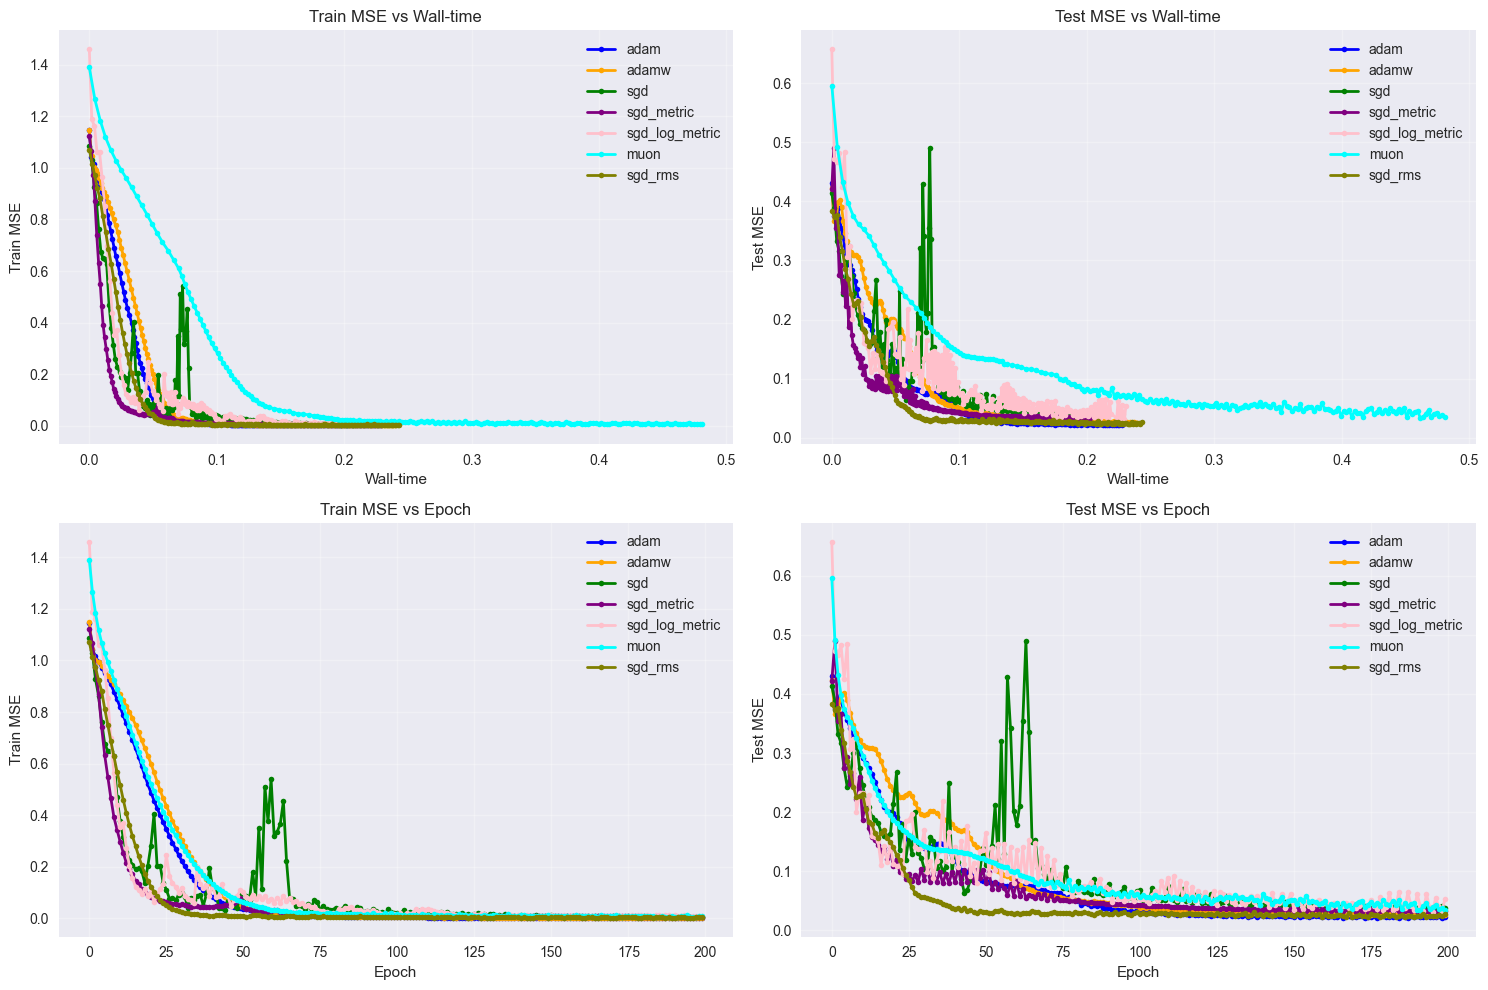

In [8]:
optimizer_colors = {
    'sgd_rms': 'olive',
    'adam': 'blue',
    'adamw': 'orange',
    'sgd': 'green',
    'sgd_metric': 'purple',
    'sgd_log_metric': 'pink',
    'muon': 'cyan'
}
# Create subplots for all optimizers
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for optimizer, data in optimizer_data.items():
    color = optimizer_colors[optimizer]
    
    # Plot Train MSE vs Wall-time (log-log scale)
    axes[0, 0].loglog(data['wall_times'], data['train_mses'], 'o-', 
                      linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Test MSE vs Wall-time (log-log scale)
    axes[0, 1].loglog(data['wall_times'], data['test_mses'], 'o-', 
                      linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Train MSE vs Epoch (log-log scale)
    axes[1, 0].loglog(data['epochs'], data['train_mses'], 'o-', 
                      linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Test MSE vs Epoch (log-log scale)
    axes[1, 1].loglog(data['epochs'], data['test_mses'], 'o-', 
                      linewidth=2, markersize=4, color=color, label=optimizer)

# Set titles and labels
axes[0, 0].set_title('Train MSE vs Wall-time')
axes[0, 0].set_xlabel('Wall-time')
axes[0, 0].set_ylabel('Train MSE')
axes[0, 0].set_ylim(10**-3.5, 10**0.5)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].set_title('Test MSE vs Wall-time')
axes[0, 1].set_xlabel('Wall-time')
axes[0, 1].set_ylabel('Test MSE')
axes[0, 1].set_ylim(10**-2, 10**0)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].set_title('Train MSE vs Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Train MSE')
axes[1, 0].set_ylim(10**-3.5, 10**.5)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].set_title('Test MSE vs Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Test MSE')
axes[1, 1].set_ylim(10**-2, 10**0)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Create subplots for all optimizers (linear scale)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for optimizer, data in optimizer_data.items():
    color = optimizer_colors[optimizer]
    
    # Plot Train MSE vs Wall-time (linear scale)
    axes[0, 0].plot(data['wall_times'], data['train_mses'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Test MSE vs Wall-time (linear scale)
    axes[0, 1].plot(data['wall_times'], data['test_mses'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Train MSE vs Epoch (linear scale)
    axes[1, 0].plot(data['epochs'], data['train_mses'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)
    
    # Plot Test MSE vs Epoch (linear scale)
    axes[1, 1].plot(data['epochs'], data['test_mses'], 'o-', 
                    linewidth=2, markersize=4, color=color, label=optimizer)

# Set titles and labels
axes[0, 0].set_title('Train MSE vs Wall-time')
axes[0, 0].set_xlabel('Wall-time')
axes[0, 0].set_ylabel('Train MSE')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

axes[0, 1].set_title('Test MSE vs Wall-time')
axes[0, 1].set_xlabel('Wall-time')
axes[0, 1].set_ylabel('Test MSE')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

axes[1, 0].set_title('Train MSE vs Epoch')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Train MSE')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

axes[1, 1].set_title('Test MSE vs Epoch')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Test MSE')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

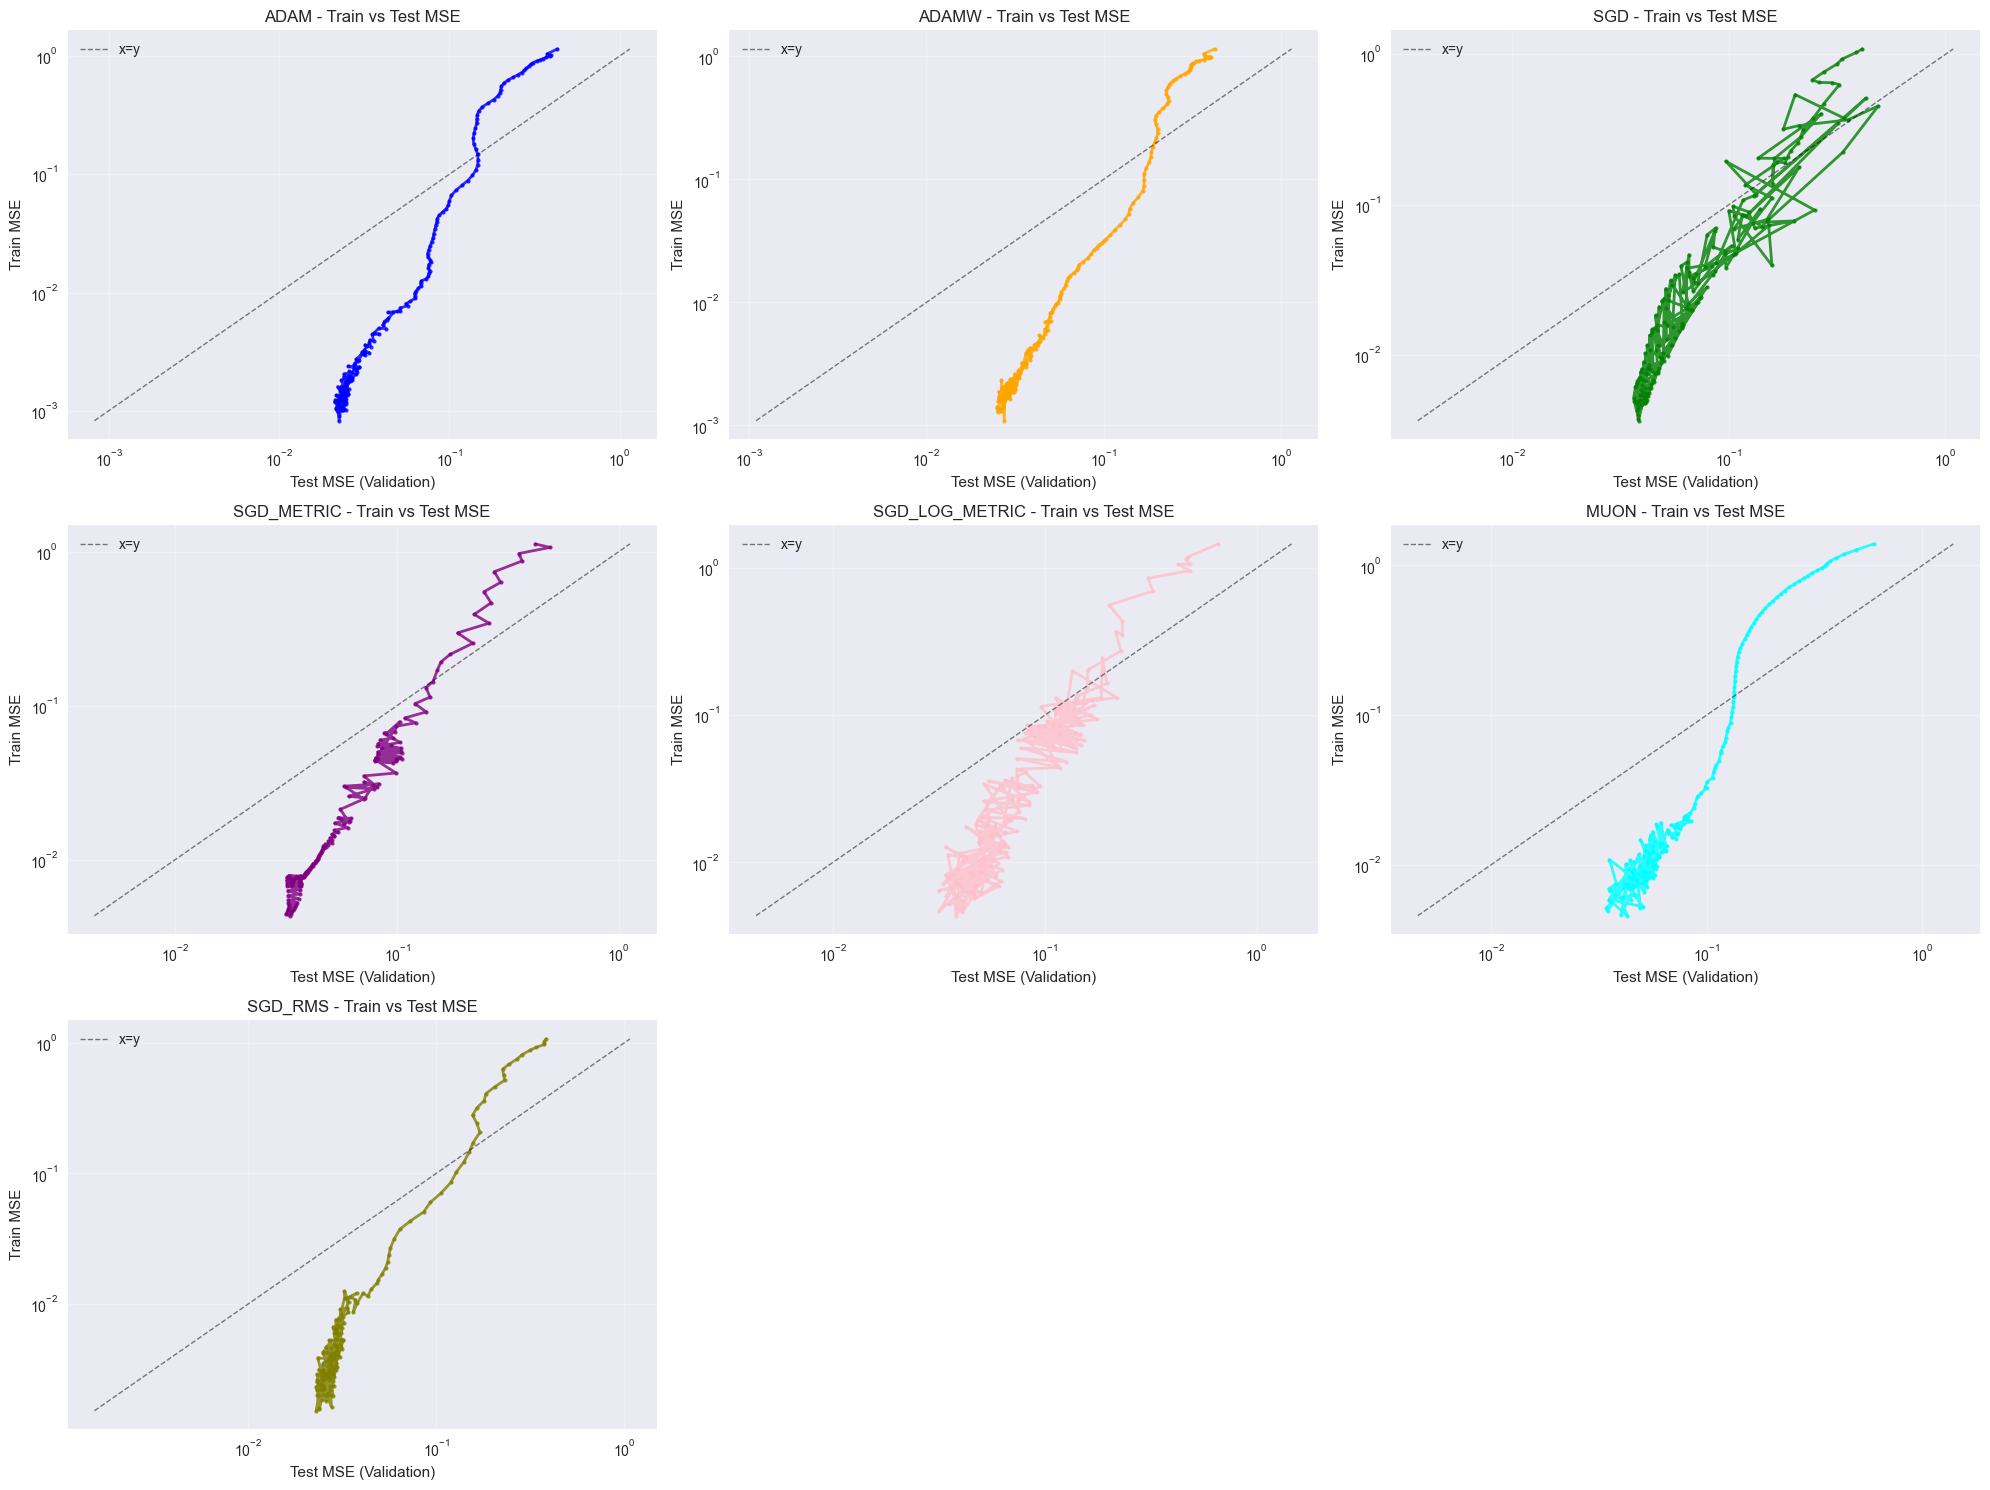

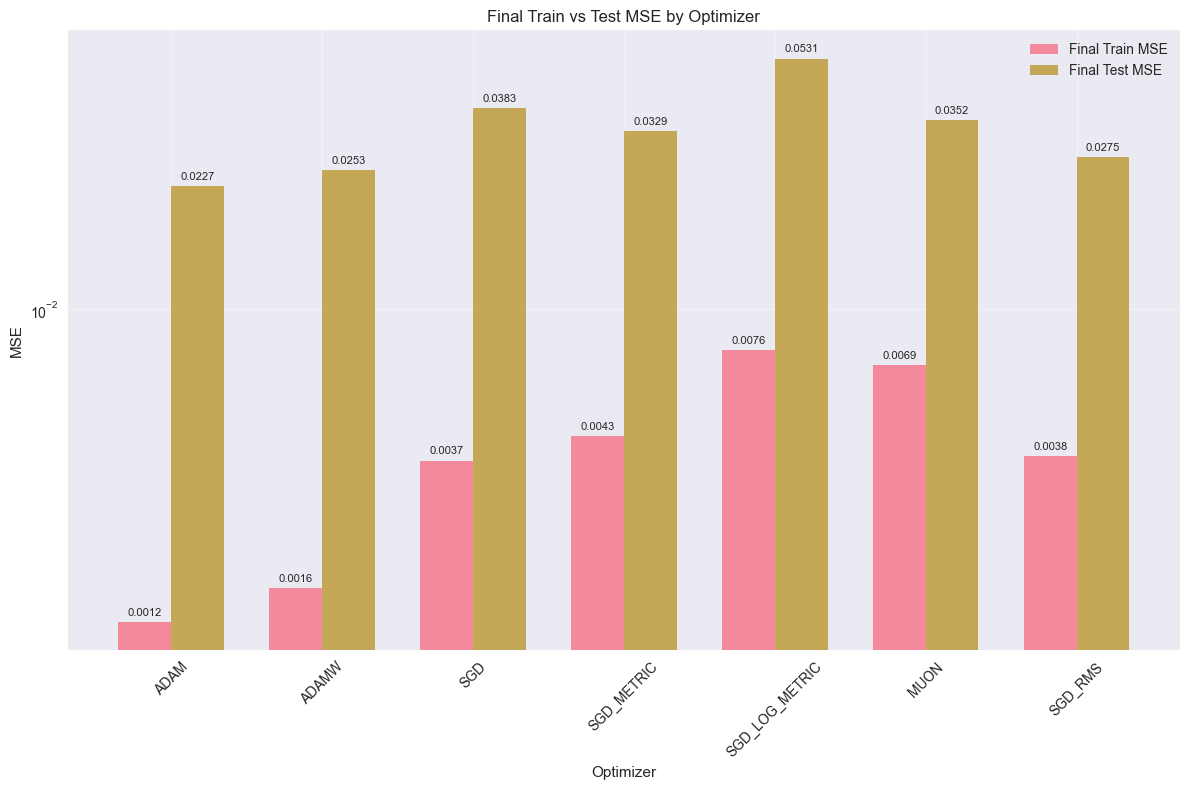

In [9]:
# Create individual plots for each optimizer showing training vs test MSE
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.flatten()

for i, (optimizer, data) in enumerate(optimizer_data.items()):
    color = optimizer_colors[optimizer]
    
    # Plot test MSE (x-axis) vs train MSE (y-axis)
    axes[i].plot(data['test_mses'], data['train_mses'], 'o-', 
                linewidth=2, markersize=3, color=color, alpha=0.8)
    
    # Add x=y line
    min_val = min(min(data['test_mses']), min(data['train_mses']))
    max_val = max(max(data['test_mses']), max(data['train_mses']))
    axes[i].plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, linewidth=1, label='x=y')
    
    # Set title and labels
    axes[i].set_title(f'{optimizer.upper()} - Train vs Test MSE')
    axes[i].set_xlabel('Test MSE (Validation)')
    axes[i].set_ylabel('Train MSE')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    
    # Set log scale for better visibility of MSE values
    axes[i].set_xscale('log')
    axes[i].set_yscale('log')

# Hide any unused subplots
for j in range(len(optimizer_data), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Create a summary plot comparing final MSEs
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

optimizers_list = list(optimizer_data.keys())
train_final = [optimizer_data[opt]['train_mses'][-1] for opt in optimizers_list]
test_final = [optimizer_data[opt]['test_mses'][-1] for opt in optimizers_list]

x_pos = np.arange(len(optimizers_list))
width = 0.35

bars1 = ax.bar(x_pos - width/2, train_final, width, label='Final Train MSE', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, test_final, width, label='Final Test MSE', alpha=0.8)

ax.set_xlabel('Optimizer')
ax.set_ylabel('MSE')
ax.set_title('Final Train vs Test MSE by Optimizer')
ax.set_xticks(x_pos)
ax.set_xticklabels([opt.upper() for opt in optimizers_list], rotation=45)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_yscale('log')  # Log scale for MSE values

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()


# Speedtests

In [10]:
# Calculate speedrun times for each target
speedrun_results = {}

for optimizer, data in optimizer_data.items():
    speedrun_results[optimizer] = {}
    
    for target in SPEEDRUN_TARGETS:
        # Find the first epoch where test MSE goes below the target
        below_target_indices = np.where(data['test_mses'] <= target)[0]
        
        if len(below_target_indices) > 0:
            first_index = below_target_indices[0]
            speedrun_results[optimizer][target] = {
                'epoch': data['epochs'][first_index],
                'wall_time': data['wall_times'][first_index],
                'test_mse': data['test_mses'][first_index]
            }
        else:
            speedrun_results[optimizer][target] = {
                'epoch': None,
                'wall_time': None,
                'test_mse': None
            }

# Create a summary table
print("Speedrun Results: Time to reach target test MSE")
print("=" * 80)

# Create header
header = f"{'Optimizer':<15}"
for target in SPEEDRUN_TARGETS:
    header += f"{target:<8}"
print(header)
print("-" * 80)

# Print results for each optimizer
for optimizer in OPTIMISERS:
    if optimizer in speedrun_results:
        row = f"{optimizer:<15}"
        for target in SPEEDRUN_TARGETS:
            result = speedrun_results[optimizer][target]
            if result['wall_time'] is not None:
                row += f"{result['wall_time']:<8.1f}"
            else:
                row += f"{'--':<8}"
        print(row)

print("\nNote: Times shown are wall-clock seconds to first achieve target test MSE")
print("'--' indicates the target was never reached during training")

# Create a more detailed table with epochs
print("\n\nDetailed Speedrun Results")
print("=" * 100)

for target in SPEEDRUN_TARGETS[:5]:  # Show first 5 targets for detail
    print(f"\nTarget Test MSE: {target}")
    print(f"{'Optimizer':<15} {'Epoch':<8} {'Wall Time (s)':<15} {'Actual MSE':<12}")
    print("-" * 50)
    
    for optimizer in OPTIMISERS:
        if optimizer in speedrun_results:
            result = speedrun_results[optimizer][target]
            if result['epoch'] is not None:
                print(f"{optimizer:<15} {result['epoch']:<8} {result['wall_time']:<15.2f} {result['test_mse']:<12.6f}")
            else:
                print(f"{optimizer:<15} {'--':<8} {'--':<15} {'--':<12}")

Speedrun Results: Time to reach target test MSE
Optimizer      0.5     0.45    0.4     0.35    0.3     0.25    0.2     0.15    0.1     0.05    
--------------------------------------------------------------------------------
adam           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.1     0.1     
adamw          0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.1     0.1     0.1     
sgd            0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.1     0.1     
sgd_metric     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.1     
sgd_log_metric 0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.1     
muon           0.0     0.0     0.0     0.0     0.0     0.1     0.1     0.1     0.2     0.3     
sgd_rms        0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.1     

Note: Times shown are wall-clock seconds to first achieve target test MSE
'--' indicates the target wa

In [11]:
# Print hyperparameters for the best runs
print("Hyperparameters for Best Runs")
print("=" * 60)

for optimizer, run in best_runs.items():
    print(f"\n{optimizer.upper()}:")
    print(f"Run name: {run.name}")
    print(f"Config:")
    
    # Get the run's config
    config = run.config
    
    # Print relevant hyperparameters
    for key, value in config.items():
        if key not in ['_wandb', 'wandb_version']:  # Skip internal wandb keys
            print(f"  {key}: {value}")
    
    # Get final metrics
    summary = run.summary
    if 'final_test_acc' in summary:
        print(f"Final test accuracy: {summary['final_test_acc']:.6f}")
    if 'max_val_acc' in summary:
        print(f"Max validation accuracy: {summary['max_val_acc']:.6f}")
    
    print("-" * 40)

Hyperparameters for Best Runs

ADAM:
Run name: fearless-sweep-454
Config:
  eps: 1e-08
  beta1: 0.9884079394705424
  beta2: 0.9755509883934016
  n_epochs: 200
  batch_size: 1024
  learning_rate: 0.006209499672691204
----------------------------------------

ADAMW:
Run name: quiet-sweep-65
Config:
  eps: 1e-08
  beta1: 0.9815029710463442
  beta2: 0.9116180809944268
  n_epochs: 200
  batch_size: 1024
  weight_decay: 0.0023978322753991942
  learning_rate: 0.004390529718424181
----------------------------------------

SGD:
Run name: autumn-sweep-136
Config:
  momentum: 0.8216092289781726
  n_epochs: 200
  batch_size: 1024
  learning_rate: 0.12102466698463996
----------------------------------------

SGD_METRIC:
Run name: pious-sweep-28
Config:
  xi: 0.0019256692883157036
  beta: 0.8785588147665602
  momentum: 0.9836082202127188
  n_epochs: 200
  batch_size: 1024
  weight_decay: 1.2260092610173866e-05
  learning_rate: 0.6674048127308755
----------------------------------------

SGD_LOG_METR

In [12]:
# Create a DataFrame with best hyperparameters for each optimizer
hyperparams_data = []

for optimizer, run in best_runs.items():
    config = run.config
    
    # Create a row with optimizer name and all hyperparameters
    row = {'optimizer': optimizer}
    
    # Add all config parameters except internal wandb keys
    for key, value in config.items():
        if key not in ['_wandb', 'wandb_version']:
            row[key] = value
    
    # Add final performance metrics
    summary = run.summary
    row['final_test_mse'] = summary.get('final_test_mse', None)
    row['final_train_mse'] = summary.get('final_train_mse', None)
    row['min_val_loss'] = summary.get('min_val_loss', None)
    row['run_name'] = run.name
    
    hyperparams_data.append(row)

# Convert to DataFrame
hyperparams_df = pd.DataFrame(hyperparams_data)

# Save to CSV with regression in filename
filename = f'best_hyperparameters_regression_run_{RUN_INDEX}.csv'
hyperparams_df.to_csv(filename, index=False)

print(f"Best hyperparameters saved to '{filename}'")
print(f"Shape: {hyperparams_df.shape}")
print("\nColumns in the dataset:")
print(hyperparams_df.columns.tolist())
print("\nFirst few rows:")
print(hyperparams_df.head())

Best hyperparameters saved to 'best_hyperparameters_regression_run_1.csv'
Shape: (7, 18)

Columns in the dataset:
['optimizer', 'eps', 'beta1', 'beta2', 'n_epochs', 'batch_size', 'learning_rate', 'final_test_mse', 'final_train_mse', 'min_val_loss', 'run_name', 'weight_decay', 'momentum', 'xi', 'beta', 'adam_b1', 'adam_b2', 'beta_rms']

First few rows:
        optimizer           eps     beta1     beta2  n_epochs  batch_size  \
0            adam  1.000000e-08  0.988408  0.975551       200        1024   
1           adamw  1.000000e-08  0.981503  0.911618       200        1024   
2             sgd           NaN       NaN       NaN       200        1024   
3      sgd_metric           NaN       NaN       NaN       200        1024   
4  sgd_log_metric           NaN       NaN       NaN       200        1024   

   learning_rate  final_test_mse  final_train_mse  min_val_loss  \
0       0.006209        0.022737         0.001249      0.021170   
1       0.004391        0.025271         0.001568

sgd_metric: 50 runs
  Mean xi: 0.018723
  Std xi: 0.024834
  Min xi: 0.001018
  Max xi: 0.093204
sgd_log_metric: 50 runs
  Mean xi: 0.030807
  Std xi: 0.026924
  Min xi: 0.001258
  Max xi: 0.097858
sgd_rms: 50 runs
  Mean xi: 0.016826
  Std xi: 0.019588
  Min xi: 0.001572
  Max xi: 0.083369


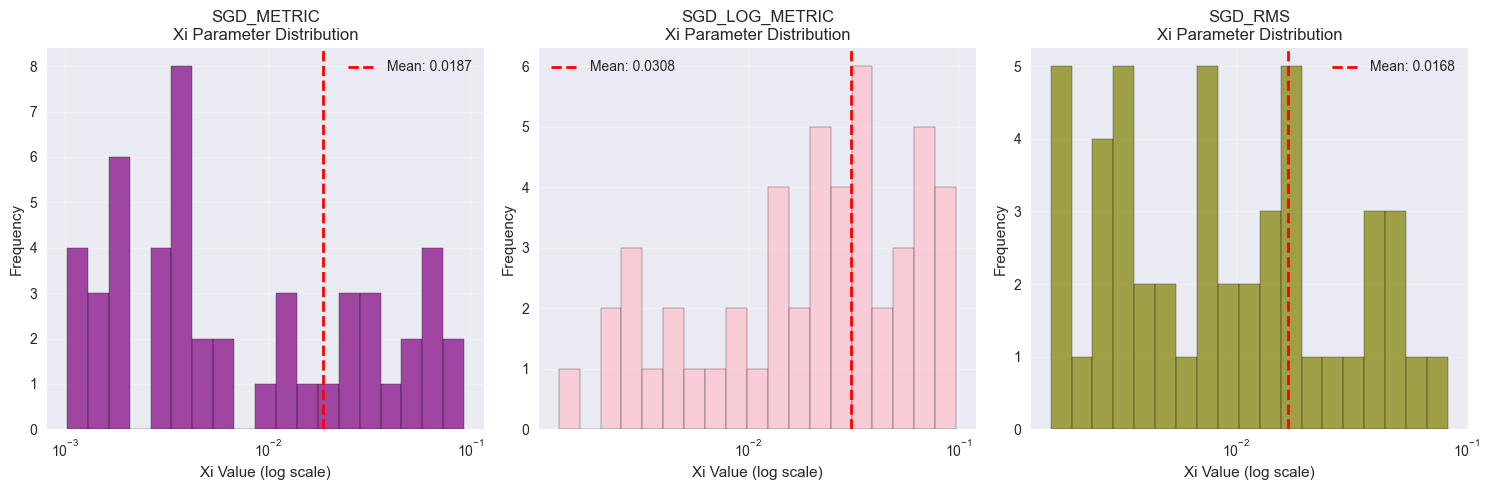

In [13]:
# Extract xi parameter values for the custom optimizers from best_50_runs
custom_optimizers = ['sgd_metric', 'sgd_log_metric', 'sgd_rms']
xi_data = {}

for optimizer in custom_optimizers:
    if optimizer in best_50_runs:
        xi_values = []
        for run in best_50_runs[optimizer]:
            xi = run.config.get('xi', None)
            if xi is not None:
                xi_values.append(xi)
        xi_data[optimizer] = xi_values

# Create histogram for xi parameter with log scale
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, optimizer in enumerate(custom_optimizers):
    if optimizer in xi_data and len(xi_data[optimizer]) > 0:
        # Use log bins for better visualization
        log_bins = np.logspace(np.log10(min(xi_data[optimizer])), 
                              np.log10(max(xi_data[optimizer])), 20)
        
        axes[i].hist(xi_data[optimizer], bins=log_bins, alpha=0.7, 
                    color=optimizer_colors[optimizer], edgecolor='black')
        axes[i].set_title(f'{optimizer.upper()}\nXi Parameter Distribution')
        axes[i].set_xlabel('Xi Value (log scale)')
        axes[i].set_ylabel('Frequency')
        axes[i].set_xscale('log')
        axes[i].grid(True, alpha=0.3)
        
        # Add statistics
        mean_xi = np.mean(xi_data[optimizer])
        std_xi = np.std(xi_data[optimizer])
        axes[i].axvline(mean_xi, color='red', linestyle='--', linewidth=2, 
                       label=f'Mean: {mean_xi:.4f}')
        axes[i].legend()
        
        print(f"{optimizer}: {len(xi_data[optimizer])} runs")
        print(f"  Mean xi: {mean_xi:.6f}")
        print(f"  Std xi: {std_xi:.6f}")
        print(f"  Min xi: {min(xi_data[optimizer]):.6f}")
        print(f"  Max xi: {max(xi_data[optimizer]):.6f}")
    else:
        axes[i].text(0.5, 0.5, f'No xi data for {optimizer}', 
                    ha='center', va='center', transform=axes[i].transAxes)
        axes[i].set_title(f'{optimizer.upper()}\n(No data)')

plt.tight_layout()
plt.show()

Note that N~200, so this is slightly larger than expected